## 1. Install Dependencies and Imports

In [23]:
import os
import json
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import models, transforms
from sklearn.metrics import accuracy_score, f1_score

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda


## 2. Data Loading - SLAKE Dataset

In [24]:
def process_slake_json(json_path, image_root_dir, min_freq=0):

    # Load JSON
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    print(f"Total samples in {json_path}: {len(data)}")

    # Filter English samples and collect answers
    english_samples = []
    all_answers = []

    for item in data:
        if item.get('q_lang') == 'en':  # Only English questions
            img_name = item['img_name']
            full_img_path = os.path.join(image_root_dir, img_name)

            question = item['question']
            answer = str(item['answer']).lower().strip()

            english_samples.append({
                'image_path': full_img_path,
                'question': question,
                'answer_text': answer,
                'answer_type': item.get('answer_type', 'OPEN')
            })
            all_answers.append(answer)

    print(f"English samples: {len(english_samples)}")

    # Build answer vocabulary
    answer_counts = Counter(all_answers)
    unique_answers = sorted([ans for ans, count in answer_counts.items() if count >= min_freq])
    answer_to_id = {ans: idx for idx, ans in enumerate(unique_answers)}

    print(f"Unique answer classes: {len(answer_to_id)}")

    # Assign labels to samples
    final_samples = []
    for sample in english_samples:
        ans = sample['answer_text']
        if ans in answer_to_id:
            sample['label'] = answer_to_id[ans]
            final_samples.append(sample)

    print(f"Final samples with valid answers: {len(final_samples)}")

    return final_samples, answer_to_id

In [25]:
# Load SLAKE data
train_data, answer_vocab = process_slake_json(
    json_path='/content/drive/MyDrive/AML_AA/Slake1.0/train.json',
    image_root_dir='/content/drive/MyDrive/AML_AA/Slake1.0/imgs',
    min_freq=0
)

#Limit to 500 Samples
print(f"\nOriginal dataset size: {len(train_data)}")
train_data = train_data[:500]  # Take only first 100 samples
print(f"Using only {len(train_data)} samples for quick testing")

# Create reverse mapping
id_to_answer = {v: k for k, v in answer_vocab.items()}


Total samples in /content/drive/MyDrive/AML_AA/Slake1.0/train.json: 9835
English samples: 4919
Unique answer classes: 221
Final samples with valid answers: 4919

Original dataset size: 4919
Using only 500 samples for quick testing


## 3. Text Preprocessing - Question Tokenization

In [26]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.word_count = Counter()

        # Special tokens
        self.pad_token = '<PAD>'
        self.unk_token = '<UNK>'

        # Initialize
        self.add_word(self.pad_token)
        self.add_word(self.unk_token)

    def add_word(self, word):
        if word not in self.word2idx:
            idx = len(self.word2idx)
            self.word2idx[word] = idx
            self.idx2word[idx] = word
        self.word_count[word] += 1

    def __len__(self):
        return len(self.word2idx)

    def __call__(self, word):
        return self.word2idx.get(word, self.word2idx[self.unk_token])


def tokenize_question(question):
    """Tokenize a question into words."""
    question = question.lower()
    question = re.sub(r'[^\w\s\-]', ' ', question)
    tokens = question.split()
    return [t for t in tokens if t]


def build_vocab(samples, min_freq=2):
    """Build vocabulary from question samples."""
    vocab = Vocabulary()

    # Count all words
    for sample in samples:
        tokens = tokenize_question(sample['question'])
        for token in tokens:
            vocab.word_count[token] += 1

    # Add words meeting min frequency
    for word, count in vocab.word_count.items():
        if count >= min_freq and word not in vocab.word2idx:
            vocab.add_word(word)

    print(f"Vocabulary size: {len(vocab)}")
    return vocab


def encode_question(question, vocab, max_length=20):
    """Encode question as tensor of token indices."""
    tokens = tokenize_question(question)
    indices = [vocab(token) for token in tokens]

    # Pad or truncate
    if len(indices) < max_length:
        indices += [vocab(vocab.pad_token)] * (max_length - len(indices))
    else:
        indices = indices[:max_length]

    return torch.tensor(indices, dtype=torch.long)

## 4. PyTorch Dataset

In [27]:
class SlakeVQADataset(Dataset):
    """SLAKE dataset for SAN model."""

    def __init__(self, samples, vocab, transform=None, max_length=20,return_answer_type=False):
        self.samples = samples
        self.vocab = vocab
        self.transform = transform
        self.max_length = max_length
        self.return_answer_type = return_answer_type

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load and transform image
        image = Image.open(sample['image_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Encode question
        question = encode_question(sample['question'], self.vocab, self.max_length)

        # Get label
        label = torch.tensor(sample['label'], dtype=torch.long)

        if self.return_answer_type:
            return image, question, label, sample.get("answer_type", "OPEN")

        return image, question, label


# Image transforms
train_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [28]:
# Split data into train/val
train_size =400
val_size = 100

train_samples, val_samples = random_split(train_data,
                                          [train_size, val_size],
                                          generator=torch.Generator().manual_seed(42))

print(f"Dataset split:")
print(f"  Training: {train_size} samples")
print(f"  Validation: {val_size} samples")

# Create datasets
train_dataset = SlakeVQADataset([train_data[i] for i in train_samples.indices],
                                question_vocab,
                                transform=train_transform,
                                max_length=20)

val_dataset = SlakeVQADataset([train_data[i] for i in val_samples.indices],
                              question_vocab,
                              transform=val_transform,
                              max_length=20,
                              return_answer_type=True)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)

print(f"\nDataLoader info:")
print(f"  Train batches: {len(train_loader)} (batch_size=16)")
print(f"  Val batches: {len(val_loader)} (batch_size=16)")

Dataset split:
  Training: 400 samples
  Validation: 100 samples

DataLoader info:
  Train batches: 25 (batch_size=16)
  Val batches: 7 (batch_size=16)


## 5. SAN Model Architecture

In [29]:
class ImageEncoder(nn.Module):
    """ResNet-152 image encoder."""

    def __init__(self, pretrained=True):
        super().__init__()
        resnet = models.resnet152(pretrained=pretrained)
        # Remove avgpool and fc layers to get spatial features
        modules = list(resnet.children())[:-2]
        self.cnn = nn.Sequential(*modules)
        self.feature_dim = 2048

    def forward(self, images):
        # images: [B, 3, 224, 224]
        # output: [B, 2048, 7, 7]
        return self.cnn(images)


class QuestionEncoder(nn.Module):
    """LSTM question encoder."""

    def __init__(self, vocab_size, embed_dim=512, hidden_dim=512, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, questions):
        # questions: [B, seq_len]
        embedded = self.embedding(questions)  # [B, seq_len, embed_dim]
        embedded = self.dropout(embedded)
        _, (hidden, _) = self.lstm(embedded)
        # Return last hidden state: [B, hidden_dim]
        return hidden.squeeze(0)


class AttentionLayer(nn.Module):
    """Single attention layer."""

    def __init__(self, image_dim, question_dim, hidden_dim=512):
        super().__init__()
        self.image_proj = nn.Conv2d(image_dim, hidden_dim, kernel_size=1)
        self.question_proj = nn.Linear(question_dim, hidden_dim)
        self.attention_proj = nn.Conv2d(hidden_dim, 1, kernel_size=1)

    def forward(self, image_features, question_embedding):
        # image_features: [B, image_dim, H, W]
        # question_embedding: [B, question_dim]

        B, C, H, W = image_features.shape

        # Project image features
        img_proj = self.image_proj(image_features)  # [B, hidden_dim, H, W]

        # Project and expand question
        q_proj = self.question_proj(question_embedding)  # [B, hidden_dim]
        q_proj = q_proj.unsqueeze(2).unsqueeze(3).expand(-1, -1, H, W)  # [B, hidden_dim, H, W]

        # Combine and compute attention
        combined = torch.tanh(img_proj + q_proj)  # [B, hidden_dim, H, W]
        attention_scores = self.attention_proj(combined)  # [B, 1, H, W]
        attention_scores = attention_scores.view(B, -1)  # [B, H*W]
        attention_weights = F.softmax(attention_scores, dim=1)  # [B, H*W]

        # Apply attention to image features
        image_flat = image_features.view(B, C, -1)  # [B, C, H*W]
        attended = torch.bmm(image_flat, attention_weights.unsqueeze(2))  # [B, C, 1]
        attended = attended.squeeze(2)  # [B, C]

        return attended, attention_weights


class StackedAttentionNetwork(nn.Module):
    """Complete SAN model."""

    def __init__(self, vocab_size, num_classes,
                 embed_dim=512, question_hidden_dim=512,
                 attention_hidden_dim=512,
                 num_attention_layers=2,dropout=0.5):
        super().__init__()

        # Encoders
        self.image_encoder = ImageEncoder(pretrained=True)
        self.question_encoder = QuestionEncoder(vocab_size, embed_dim, question_hidden_dim, dropout)

        # Freeze CNN for faster training (optional)
        for param in self.image_encoder.parameters():
            param.requires_grad = False

        # Stacked attention layers
        self.attention_layers = nn.ModuleList([
            AttentionLayer(2048, question_hidden_dim, attention_hidden_dim)
            for _ in range(num_attention_layers)
        ])

        # Classifier
        combined_dim = 2048 + question_hidden_dim
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(combined_dim, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, num_classes)
        )

    def forward(self, images, questions):
        # Encode
        image_features = self.image_encoder(images)
        question_embedding = self.question_encoder(questions)

        # Apply stacked attention
        attended_image = image_features
        for attention_layer in self.attention_layers:
            attended_features, _ = attention_layer(attended_image, question_embedding)
            # Refine attention by adding attended features back
            B, C, H, W = attended_image.shape
            attended_expanded = attended_features.unsqueeze(2).unsqueeze(3).expand(-1, -1, H, W)
            attended_image = attended_image + attended_expanded

        # Get final attended features
        final_attended, _ = self.attention_layers[-1](attended_image, question_embedding)

        # Combine and classify
        combined = torch.cat([final_attended, question_embedding], dim=1)
        logits = self.classifier(combined)

        return logits

In [30]:
# Initialize model
model = StackedAttentionNetwork(vocab_size=len(question_vocab),
                                num_classes=len(answer_vocab),
                                embed_dim=512,
                                question_hidden_dim=512,
                                attention_hidden_dim=512,
                                num_attention_layers=2,
                                dropout=0.5).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters: 65,742,623
Trainable parameters: 7,598,815


## 6. Training Loop

In [31]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    pbar = tqdm(dataloader, desc="Training")
    for images, questions, labels in pbar:
        images = images.to(device)
        questions = questions.to(device)
        labels = labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(images, questions)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    open_correct = open_total = 0
    closed_correct = closed_total = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
          if len(batch) == 4:
            images, questions, labels, answer_types = batch
          else:
            images, questions, labels = batch
            answer_types = None

          images = images.to(device)
          questions = questions.to(device)
          labels = labels.to(device)

          outputs = model(images, questions)
          loss = criterion(outputs, labels)

          running_loss += loss.item()
          preds = torch.argmax(outputs, dim=1)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

          # If answer_types exists, compute open/closed accuracy
          if answer_types is not None:
            correct = (preds.cpu() == labels.cpu())
            for c, t in zip(correct.numpy().tolist(), answer_types):
                if t == "OPEN":
                    open_total += 1
                    open_correct += int(c)
                elif t == "CLOSED":
                    closed_total += 1
                    closed_correct += int(c)

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, epoch_f1


def train_model(model, train_loader, val_loader, num_epochs=30, lr=1e-4):
    """Complete training loop."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                      factor=0.5, patience=3)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
    best_val_acc = 0.0

    print(f"\nStarting training for {num_epochs} epochs...\n")

    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")
        print("-" * 50)

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc, val_f1 = validate(model, val_loader, criterion, device)

        # Update scheduler
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']

        # Print if learning rate changed
        if old_lr != new_lr:
            print(f"Learning rate reduced: {old_lr:.6f} -> {new_lr:.6f}")

        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        # Print results
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'best_san_model.pth')
            print(f"✓ Best model saved! (Val Acc: {val_acc:.4f})")

        print()

    print(f"Training complete! Best Val Acc: {best_val_acc:.4f}")

    return history

In [32]:
# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    lr=1e-4
)


Starting training for 50 epochs...

Epoch 1/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]


Train Loss: 4.1247 | Train Acc: 0.1275
Val Loss: 2.9005 | Val Acc: 0.2200 | Val F1: 0.1107
✓ Best model saved! (Val Acc: 0.2200)

Epoch 2/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Train Loss: 3.2378 | Train Acc: 0.1225
Val Loss: 2.7562 | Val Acc: 0.2200 | Val F1: 0.1104

Epoch 3/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:01<00:00,  3.51it/s]


Train Loss: 3.0690 | Train Acc: 0.1525
Val Loss: 2.7076 | Val Acc: 0.1500 | Val F1: 0.0813

Epoch 4/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Train Loss: 2.8587 | Train Acc: 0.1975
Val Loss: 2.4675 | Val Acc: 0.3300 | Val F1: 0.2338
✓ Best model saved! (Val Acc: 0.3300)

Epoch 5/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


Train Loss: 2.5466 | Train Acc: 0.2650
Val Loss: 2.2731 | Val Acc: 0.2900 | Val F1: 0.2504

Epoch 6/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


Train Loss: 2.3474 | Train Acc: 0.3150
Val Loss: 2.2028 | Val Acc: 0.2200 | Val F1: 0.1825

Epoch 7/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


Train Loss: 2.2929 | Train Acc: 0.3250
Val Loss: 2.2641 | Val Acc: 0.3500 | Val F1: 0.2605
✓ Best model saved! (Val Acc: 0.3500)

Epoch 8/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


Train Loss: 2.2121 | Train Acc: 0.3175
Val Loss: 2.2022 | Val Acc: 0.3900 | Val F1: 0.3490
✓ Best model saved! (Val Acc: 0.3900)

Epoch 9/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Train Loss: 2.0909 | Train Acc: 0.3925
Val Loss: 2.1031 | Val Acc: 0.4900 | Val F1: 0.4157
✓ Best model saved! (Val Acc: 0.4900)

Epoch 10/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


Train Loss: 2.0517 | Train Acc: 0.3875
Val Loss: 2.0211 | Val Acc: 0.4100 | Val F1: 0.3908

Epoch 11/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Train Loss: 1.9040 | Train Acc: 0.4475
Val Loss: 2.0785 | Val Acc: 0.4400 | Val F1: 0.4008

Epoch 12/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Train Loss: 1.8751 | Train Acc: 0.4225
Val Loss: 2.0231 | Val Acc: 0.3600 | Val F1: 0.3541

Epoch 13/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.71it/s]


Train Loss: 1.9116 | Train Acc: 0.4325
Val Loss: 1.9935 | Val Acc: 0.3900 | Val F1: 0.3733

Epoch 14/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Train Loss: 1.8788 | Train Acc: 0.4525
Val Loss: 2.0425 | Val Acc: 0.4700 | Val F1: 0.4004

Epoch 15/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


Train Loss: 1.8142 | Train Acc: 0.4225
Val Loss: 2.0974 | Val Acc: 0.3600 | Val F1: 0.3400

Epoch 16/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


Train Loss: 1.7731 | Train Acc: 0.4525
Val Loss: 2.0297 | Val Acc: 0.3600 | Val F1: 0.3516

Epoch 17/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


Learning rate reduced: 0.000100 -> 0.000050
Train Loss: 1.7344 | Train Acc: 0.4475
Val Loss: 2.0270 | Val Acc: 0.3900 | Val F1: 0.3747

Epoch 18/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


Train Loss: 1.7004 | Train Acc: 0.4600
Val Loss: 2.0177 | Val Acc: 0.3200 | Val F1: 0.3109

Epoch 19/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


Train Loss: 1.6485 | Train Acc: 0.4850
Val Loss: 2.0349 | Val Acc: 0.3400 | Val F1: 0.3351

Epoch 20/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]


Train Loss: 1.6577 | Train Acc: 0.4650
Val Loss: 2.0031 | Val Acc: 0.3500 | Val F1: 0.3414

Epoch 21/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Learning rate reduced: 0.000050 -> 0.000025
Train Loss: 1.6826 | Train Acc: 0.4500
Val Loss: 2.0339 | Val Acc: 0.3400 | Val F1: 0.3376

Epoch 22/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


Train Loss: 1.5828 | Train Acc: 0.4925
Val Loss: 2.0281 | Val Acc: 0.3300 | Val F1: 0.3337

Epoch 23/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


Train Loss: 1.5574 | Train Acc: 0.4750
Val Loss: 2.0347 | Val Acc: 0.3400 | Val F1: 0.3370

Epoch 24/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


Train Loss: 1.5535 | Train Acc: 0.4900
Val Loss: 2.0351 | Val Acc: 0.3600 | Val F1: 0.3553

Epoch 25/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


Learning rate reduced: 0.000025 -> 0.000013
Train Loss: 1.6125 | Train Acc: 0.4950
Val Loss: 2.0472 | Val Acc: 0.3400 | Val F1: 0.3440

Epoch 26/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


Train Loss: 1.5893 | Train Acc: 0.4625
Val Loss: 2.0552 | Val Acc: 0.3500 | Val F1: 0.3527

Epoch 27/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Train Loss: 1.6004 | Train Acc: 0.4825
Val Loss: 2.0387 | Val Acc: 0.3600 | Val F1: 0.3581

Epoch 28/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]


Train Loss: 1.5749 | Train Acc: 0.4825
Val Loss: 2.0500 | Val Acc: 0.3600 | Val F1: 0.3583

Epoch 29/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.42it/s]


Learning rate reduced: 0.000013 -> 0.000006
Train Loss: 1.5931 | Train Acc: 0.4975
Val Loss: 2.0470 | Val Acc: 0.3400 | Val F1: 0.3433

Epoch 30/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:01<00:00,  3.50it/s]


Train Loss: 1.5477 | Train Acc: 0.4875
Val Loss: 2.0500 | Val Acc: 0.3700 | Val F1: 0.3684

Epoch 31/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


Train Loss: 1.5559 | Train Acc: 0.5100
Val Loss: 2.0415 | Val Acc: 0.3700 | Val F1: 0.3684

Epoch 32/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


Train Loss: 1.4969 | Train Acc: 0.5125
Val Loss: 2.0487 | Val Acc: 0.3500 | Val F1: 0.3516

Epoch 33/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.44it/s]


Learning rate reduced: 0.000006 -> 0.000003
Train Loss: 1.5596 | Train Acc: 0.4450
Val Loss: 2.0409 | Val Acc: 0.3500 | Val F1: 0.3460

Epoch 34/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Train Loss: 1.5328 | Train Acc: 0.5000
Val Loss: 2.0454 | Val Acc: 0.3600 | Val F1: 0.3591

Epoch 35/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]


Train Loss: 1.5688 | Train Acc: 0.4650
Val Loss: 2.0508 | Val Acc: 0.3400 | Val F1: 0.3425

Epoch 36/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Train Loss: 1.5599 | Train Acc: 0.4875
Val Loss: 2.0493 | Val Acc: 0.3500 | Val F1: 0.3516

Epoch 37/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Learning rate reduced: 0.000003 -> 0.000002
Train Loss: 1.5745 | Train Acc: 0.4625
Val Loss: 2.0514 | Val Acc: 0.3500 | Val F1: 0.3512

Epoch 38/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


Train Loss: 1.5156 | Train Acc: 0.4825
Val Loss: 2.0627 | Val Acc: 0.3400 | Val F1: 0.3462

Epoch 39/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.49it/s]


Train Loss: 1.5967 | Train Acc: 0.4625
Val Loss: 2.0574 | Val Acc: 0.3400 | Val F1: 0.3433

Epoch 40/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.50it/s]


Train Loss: 1.5571 | Train Acc: 0.4800
Val Loss: 2.0625 | Val Acc: 0.3500 | Val F1: 0.3492

Epoch 41/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


Learning rate reduced: 0.000002 -> 0.000001
Train Loss: 1.6039 | Train Acc: 0.4775
Val Loss: 2.0632 | Val Acc: 0.3400 | Val F1: 0.3415

Epoch 42/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


Train Loss: 1.5582 | Train Acc: 0.4675
Val Loss: 2.0609 | Val Acc: 0.3500 | Val F1: 0.3492

Epoch 43/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Train Loss: 1.5045 | Train Acc: 0.4950
Val Loss: 2.0612 | Val Acc: 0.3400 | Val F1: 0.3410

Epoch 44/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


Train Loss: 1.5489 | Train Acc: 0.4600
Val Loss: 2.0639 | Val Acc: 0.3300 | Val F1: 0.3347

Epoch 45/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]


Learning rate reduced: 0.000001 -> 0.000000
Train Loss: 1.5134 | Train Acc: 0.5150
Val Loss: 2.0605 | Val Acc: 0.3400 | Val F1: 0.3459

Epoch 46/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


Train Loss: 1.5589 | Train Acc: 0.4525
Val Loss: 2.0629 | Val Acc: 0.3400 | Val F1: 0.3464

Epoch 47/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.48it/s]


Train Loss: 1.4635 | Train Acc: 0.5175
Val Loss: 2.0603 | Val Acc: 0.3400 | Val F1: 0.3408

Epoch 48/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:01<00:00,  3.52it/s]


Train Loss: 1.5328 | Train Acc: 0.4700
Val Loss: 2.0648 | Val Acc: 0.3500 | Val F1: 0.3532

Epoch 49/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Learning rate reduced: 0.000000 -> 0.000000
Train Loss: 1.5548 | Train Acc: 0.4875
Val Loss: 2.0577 | Val Acc: 0.3300 | Val F1: 0.3323

Epoch 50/50
--------------------------------------------------


Validating: 100%|██████████| 7/7 [00:02<00:00,  2.78it/s]

Train Loss: 1.5004 | Train Acc: 0.4925
Val Loss: 2.0611 | Val Acc: 0.3400 | Val F1: 0.3433

Training complete! Best Val Acc: 0.4900


## 7. Evaluation and Visualization

In [33]:
def evaluate_model(model, dataloader, device, id_to_answer):
    """Evaluation with Overall + Open/Closed separated scores."""
    model.eval()

    all_preds = []
    all_labels = []
    all_types = []   # OPEN/CLOSED per sample

    print("Evaluating model...")
    with torch.no_grad():
        for batch in tqdm(dataloader):
            # Support BOTH:
            # (images, questions, labels)  OR  (images, questions, labels, answer_types)
            if len(batch) == 4:
                images, questions, labels, answer_types = batch
                all_types.extend(list(answer_types))
            else:
                images, questions, labels = batch
                all_types.extend(["UNKNOWN"] * len(labels))

            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            outputs = model(images, questions)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_types = np.array(all_types)

    # ===== Overall metrics =====
    overall_acc = accuracy_score(all_labels, all_preds)
    overall_f1  = f1_score(all_labels, all_preds, average='weighted')

    # ===== Open / Closed split =====
    open_mask = (all_types == "OPEN")
    closed_mask = (all_types == "CLOSED")

    # Safe handling if no samples exist
    open_acc = accuracy_score(all_labels[open_mask], all_preds[open_mask]) if open_mask.any() else 0.0
    closed_acc = accuracy_score(all_labels[closed_mask], all_preds[closed_mask]) if closed_mask.any() else 0.0

    open_f1 = f1_score(all_labels[open_mask], all_preds[open_mask], average='weighted') if open_mask.any() else 0.0
    closed_f1 = f1_score(all_labels[closed_mask], all_preds[closed_mask], average='weighted') if closed_mask.any() else 0.0

    # ===== Print results =====
    print(f"\n{'='*60}")
    print("EVALUATION RESULTS (Overall + Open/Closed)")
    print(f"{'='*60}")
    print(f"Overall Accuracy : {overall_acc:.4f}")
    print(f"Overall F1 (w)   : {overall_f1:.4f}")
    print(f"Total Samples    : {len(all_labels)}")

    if open_mask.any() or closed_mask.any():
        print(f"\n--- By Answer Type ---")
        print(f"OPEN   -> Acc: {open_acc:.4f} | F1(w): {open_f1:.4f} | N={open_mask.sum()}")
        print(f"CLOSED -> Acc: {closed_acc:.4f} | F1(w): {closed_f1:.4f} | N={closed_mask.sum()}")

    return {
        "overall_acc": overall_acc,
        "overall_f1": overall_f1,
        "open_acc": open_acc,
        "open_f1": open_f1,
        "closed_acc": closed_acc,
        "closed_f1": closed_f1,
        "predictions": all_preds,
        "labels": all_labels,
        "types": all_types
    }
results = evaluate_model(model, val_loader, device, id_to_answer)

def plot_training_curves(history):
    """Plot training curves."""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    ax1.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(epochs, history['val_loss'], label='Val Loss', marker='x')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss SAN')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Accuracy
    ax2.plot(epochs, history['train_acc'], label='Train Acc', marker='o')
    ax2.plot(epochs, history['val_acc'], label='Val Acc', marker='x')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy SAN')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Training curves saved to 'training_curves.png'")

def plot_open_closed_scores(results):
    metrics = ["Accuracy", "F1 (Weighted)"]
    open_scores = [results["open_acc"], results["open_f1"]]
    closed_scores = [results["closed_acc"], results["closed_f1"]]

    x = range(len(metrics))

    plt.figure(figsize=(7, 5))
    plt.bar([i - 0.2 for i in x], open_scores, width=0.4, label="OPEN")
    plt.bar([i + 0.2 for i in x], closed_scores, width=0.4, label="CLOSED")

    plt.xticks(list(x), metrics)
    plt.ylim(0, 1.0)
    plt.title("Evaluation: OPEN vs CLOSED (SLAKE English)")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()




Evaluating model...


100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


EVALUATION RESULTS (Overall + Open/Closed)
Overall Accuracy : 0.3400
Overall F1 (w)   : 0.3433
Total Samples    : 100

--- By Answer Type ---
OPEN   -> Acc: 0.4561 | F1(w): 0.4634 | N=57
CLOSED -> Acc: 0.1860 | F1(w): 0.2345 | N=43


Loaded best model from epoch 14
Evaluating model...


100%|██████████| 7/7 [00:02<00:00,  2.59it/s]



EVALUATION RESULTS (Overall + Open/Closed)
Overall Accuracy : 0.4600
Overall F1 (w)   : 0.4036
Total Samples    : 100

--- By Answer Type ---
OPEN   -> Acc: 0.5738 | F1(w): 0.5138 | N=61
CLOSED -> Acc: 0.2821 | F1(w): 0.2897 | N=39


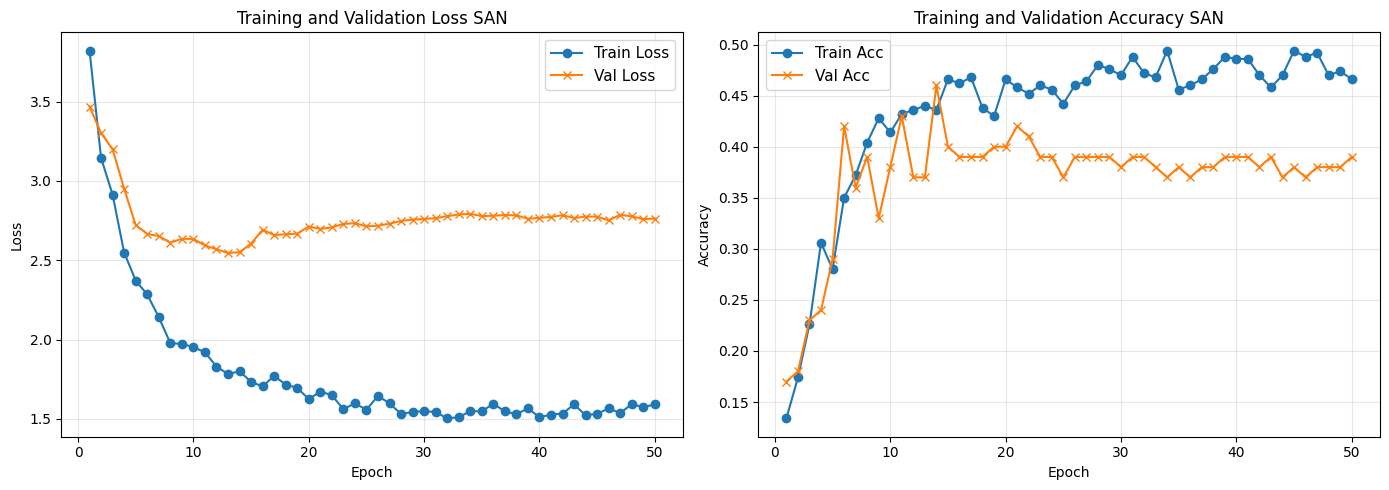

Training curves saved to 'training_curves.png'


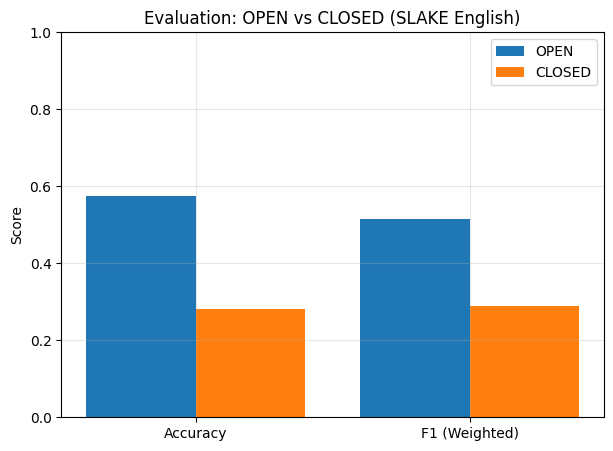


Summary Table:
Type       Accuracy   F1(w)     
--------------------------------
Overall    0.4600     0.4036    
OPEN       0.5738     0.5138    
CLOSED     0.2821     0.2897    


In [23]:
# Load best model
checkpoint = torch.load('best_san_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")

# Evaluate
results = evaluate_model(model, val_loader, device, id_to_answer)

# Plot training curves
plot_training_curves(history)

plot_open_closed_scores(results)

print("\nSummary Table:")
print(f"{'Type':<10} {'Accuracy':<10} {'F1(w)':<10}")
print(f"{'-'*32}")
print(f"{'Overall':<10} {results['overall_acc']:<10.4f} {results['overall_f1']:<10.4f}")
print(f"{'OPEN':<10} {results['open_acc']:<10.4f} {results['open_f1']:<10.4f}")
print(f"{'CLOSED':<10} {results['closed_acc']:<10.4f} {results['closed_f1']:<10.4f}")

## 8. Inference on New Samples

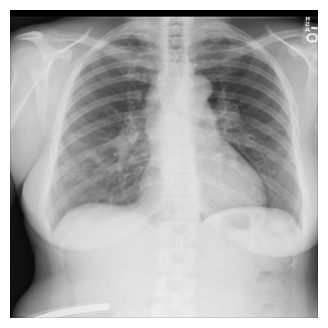

Q: Which part of the body does this image belong to?
Type: OPEN
GT: chest
PRED: chest
------------------------------------------------------------


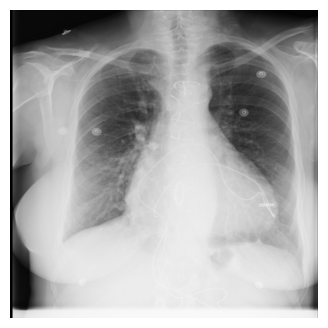

Q: Which part of the body does this image belong to?
Type: OPEN
GT: chest
PRED: chest
------------------------------------------------------------


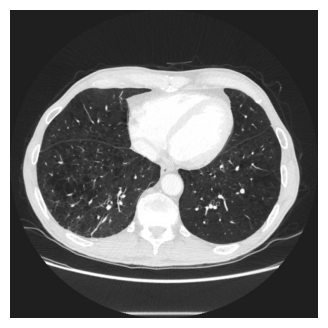

Q: Which part of the body does this image belong to?
Type: OPEN
GT: chest
PRED: chest
------------------------------------------------------------


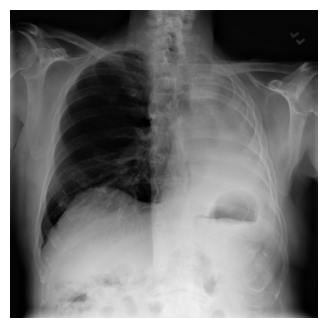

Q: Which organ is abnormal, heart or lung?
Type: CLOSED
GT: lung
PRED: yes
------------------------------------------------------------


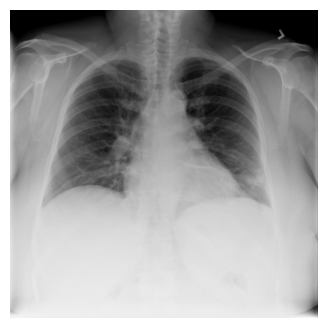

Q: Where is/are the abnormality located?
Type: OPEN
GT: both lung
PRED: lung
------------------------------------------------------------


In [34]:
from PIL import Image

def inference_demo(model, samples, id_to_answer, device, n=5):
    model.eval()
    for i in range(n):
        s = samples[i]

        # Load image
        img = Image.open(s["image_path"]).convert("RGB")

        # Prepare input
        x_img = val_transform(img).unsqueeze(0).to(device)
        x_q = encode_question(s["question"], question_vocab, 20).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(x_img, x_q)
            pred_id = logits.argmax(dim=1).item()

        pred_ans = id_to_answer[pred_id]
        true_ans = s["answer_text"]

        # Show
        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.axis("off")
        plt.show()

        print(f"Q: {s['question']}")
        print(f"Type: {s.get('answer_type','?')}")
        print(f"GT: {true_ans}")
        print(f"PRED: {pred_ans}")
        print("-" * 60)

# Example: run on validation samples
inference_demo(model, val_dataset.samples, id_to_answer, device, n=5)


## Summary

This notebook contains:
1. ✅ Data loading for SLAKE dataset (**100 samples only**)
2. ✅ Text preprocessing and vocabulary building
3. ✅ PyTorch Dataset and DataLoader
4. ✅ Complete SAN model architecture
5. ✅ Training loop with validation
6. ✅ Evaluation function
7. ✅ Visualization of training curves
8. ✅ Inference function for new samples

**Configuration:**
- Total samples: 100
- Training samples: 80
- Validation samples: 20
- Batch size: 16
- Epochs: 20

**To use this notebook:**
1. Update the paths to your SLAKE dataset in the data loading cell
2. Run all cells in order
3. The model will train on 80 samples and validate on 20 samples
4. Best checkpoint will be saved automatically
5. Use the predict function for inference on new samples

**Note:** For production training, remove the `.[:100]` slice in the data loading cell to use the full dataset.